# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from torchvision import models

import mlflow
from lightning.pytorch.loggers import MLFlowLogger

import matplotlib.pyplot as plt

from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping


torch.set_float32_matmul_precision('medium')


# Data Module

## Custom Dataset

In [ ]:
class LoLDataset(Dataset):
    def __init__(self, dark_dir, bright_dir, transform):
        self.dark_dir = dark_dir
        self.bright_dir = bright_dir
        self.transform = transform
        
        # PRO FIX: Read and sort BOTH folders independently
        self.dark_images = sorted([f for f in os.listdir(dark_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.bright_images = sorted([f for f in os.listdir(bright_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        
        # Quick safety print if there's a mismatch in folder sizes
        if len(self.dark_images) != len(self.bright_images):
            print(f"⚠️ WARNING: Found {len(self.dark_images)} dark but {len(self.bright_images)} bright in {dark_dir.split('/')[-2]}")

    def __len__(self): 
        # Safely return the smaller count so it never asks for an index that doesn't exist
        return min(len(self.dark_images), len(self.bright_images))

    def __getitem__(self, idx):
        # Uses the specific filename found in each respective folder
        dark_path = os.path.join(self.dark_dir, self.dark_images[idx])
        bright_path = os.path.join(self.bright_dir, self.bright_images[idx])
        
        dark_img = Image.open(dark_path).convert("RGB")
        bright_img = Image.open(bright_path).convert("RGB")
        
        return self.transform(dark_img), self.transform(bright_img)

## Lightning DataModule

In [ ]:
class LoLDataModule(pl.LightningDataModule):
    def __init__(self, base_path, batch_size=8):
        super().__init__()
        # Pointing to the specific subfolders
        self.train_low = os.path.join(base_path, "our485/low")
        self.train_high = os.path.join(base_path, "our485/high")
        self.val_low = os.path.join(base_path, "eval15/low")
        self.val_high = os.path.join(base_path, "eval15/high")
        
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def setup(self, stage=None):
        # Training set
        self.train_ds = LoLDataset(self.train_low, self.train_high, self.transform)
        # Validation set
        self.val_ds = LoLDataset(self.val_low, self.val_high, self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=4, persistent_workers=True, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)

## Testing 

In [ ]:
# --- TEST BLOCK 3 ---
def test_datamodule():
    print("Testing DataModule...")
    # Point to the folder
    dm = LoLDataModule(base_path="lol_dataset") 
    dm.setup()
    
    # Check Training Set
    train_loader = dm.train_dataloader()
    dark_batch, bright_batch = next(iter(train_loader))
    
    print(f"Total training samples found: {len(dm.train_ds)}")
    print(f"Total validation samples found: {len(dm.val_ds)}")
    print(f"Batch Shape (Dark): {dark_batch.shape}")
    print(f"Batch Shape (Bright): {bright_batch.shape}")
    
    # Check if pixels are normalized (should be between 0 and 1)
    print(f"Pixel Range: {dark_batch.min():.2f} to {dark_batch.max():.2f}")
    print("DataModule is ready to feed the model.\n")

test_datamodule()

Testing DataModule...
Total training samples found: 485
Total validation samples found: 15
Batch Shape (Dark): torch.Size([8, 3, 224, 224])
Batch Shape (Bright): torch.Size([8, 3, 224, 224])
Pixel Range: 0.00 to 0.50
DataModule is ready to feed the model.



# Architecture

In [ ]:
class NanoLILY(nn.Module):
    def __init__(self):
        super(NanoLILY, self).__init__()

        # --- BRANCH A: THE ARTIST ---
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.dec1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.final_spatial = nn.Conv2d(32, 3, kernel_size=3, padding=1)

        # --- BRANCH B: THE SIEVE ---
        # Initialize with SMALL values (0.01) so it doesn't overwhelm the image early on
        self.freq_mask = nn.Parameter(torch.full((1, 3, 224, 113), 0.01))

        # --- THE FUSION ---
        self.fusion = nn.Sequential(
            nn.Conv2d(6, 3, kernel_size=1),
            nn.Tanh() # Constrains the residual to a stable range [-1, 1]
        )

    def forward(self, x):
        identity = x
        
        # Spatial Pass
        s1 = self.enc1(x)
        s2 = self.enc2(s1)
        up1 = self.dec1(s2)
        spatial_out = self.final_spatial(up1 + s1) 

        # Frequency Pass
        x_fft = torch.fft.rfft2(x)
        x_fft_filtered = x_fft * self.freq_mask
        freq_out = torch.fft.irfft2(x_fft_filtered, s=(224, 224))

        # Fusion
        combined = torch.cat([spatial_out, freq_out], dim=1)
        residual = self.fusion(combined)

        return identity + residual

In [ ]:
# --- TEST ---
model = NanoLILY()
sample_input = torch.randn(1, 3, 224, 224)
output = model(sample_input)
print(f"Success! Output Shape: {output.shape}")

Success! Output Shape: torch.Size([1, 3, 224, 224])


# The Perceptual Loss

In [ ]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # We only need the feature extraction layers
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        # Slicing up to layer 18 (ReLU 4_2)
        self.slice = nn.Sequential(*list(vgg.children())[:18]).eval()
        # Freezing parameters so we don't train VGG
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, output, target):
        output_feat = self.slice(output)
        target_feat = self.slice(target)
        return F.mse_loss(output_feat, target_feat)

In [27]:
# --- TEST ---
def test_vgg_loss():
    print("Testing VGG Loss...")
    criterion = VGGPerceptualLoss()
    
    # Create two slightly different fake images
    img1 = torch.randn(1, 3, 224, 224)
    img2 = img1 + 0.1 # Just a slight difference
    
    loss = criterion(img1, img2)
    print(f"VGG Loss Output: {loss.item():.4f}")
    print("VGG Loss is working correctly.\n")

test_vgg_loss()

Testing VGG Loss...
VGG Loss Output: 0.0034
VGG Loss is working correctly.



# The Training System 

In [ ]:
class NanoLILYSystem(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
        # Losses
        self.pixel_loss = nn.L1Loss()
        self.vgg_loss = VGGPerceptualLoss()
        
        # Metrics (higher is better for both)
        self.psnr = PeakSignalNoiseRatio(data_range=1.0)
        self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        dark, bright = batch
        output = self.model(dark)

        # 1. Base Losses
        l_pixel = self.pixel_loss(output, bright)
        l_vgg = self.vgg_loss(output, bright)
        
        # FFT (The stable anchor)
        out_fft = torch.fft.rfft2(output.float(), norm="ortho") 
        tar_fft = torch.fft.rfft2(bright.float(), norm="ortho")
        l_fft = F.l1_loss(torch.abs(out_fft), torch.abs(tar_fft))

        # SSIM Loss
        ssim_val = self.ssim(output, bright)
        l_ssim = 1.0 - ssim_val 
        
        # --- DYNAMIC WEIGHTING (The Pivot Strategy) ---
        if self.current_epoch < 50:
            w_ssim = 0.01 
            w_pixel = 1.0
        else:
            w_ssim = 0.2  # Boosting structure after illumination is learned
            w_pixel = 1.0
            
        total_loss = (w_pixel * l_pixel) + (w_ssim * l_ssim) + (0.05 * l_vgg) + (0.05 * l_fft)

        # 2. Metrics & Logging
        psnr_val = self.psnr(output, bright)
        
        self.log_dict({
            "train_loss": total_loss,
            "train_psnr": psnr_val,
            "train_ssim_score": ssim_val,
            "train_l_loss": l_pixel,
            "ssim_weight": w_ssim,
            "epoch": self.current_epoch
        }, prog_bar=True, on_step=False, on_epoch=True)
        
        return total_loss

    def validation_step(self, batch, batch_idx):
        dark, bright = batch
        output = self.model(dark)
        
        # 1. Calculate Full Multi-Part Validation Loss (to match training)
        l_pixel = self.pixel_loss(output, bright)
        l_vgg = self.vgg_loss(output, bright)
        
        # FFT (Stable ortho norm)
        out_fft = torch.fft.rfft2(output.float(), norm="ortho") 
        tar_fft = torch.fft.rfft2(bright.float(), norm="ortho")
        l_fft = F.l1_loss(torch.abs(out_fft), torch.abs(tar_fft))

        ssim_val = self.ssim(output, bright)
        l_ssim = 1.0 - ssim_val 

        # Use the Phase 1 / Phase 2 weight logic
        w_ssim = 0.01 if self.current_epoch < 50 else 0.2
        val_loss = l_pixel + (w_ssim * l_ssim) + (0.05 * l_vgg) + (0.05 * l_fft)

        # 2.------THE SCHEDULER PROXY (The Delay Hack)-------
        if self.current_epoch < 50:
            sched_target = 100.0 - self.current_epoch # Fake improvement to keep LR high
        else:
            sched_target = val_loss # Real loss tracking starts now
        #-----------------------------------------------------
        
        # 3. Logging
        self.log_dict({
            "val_loss": val_loss,
            "sched_target": sched_target,
            "val_psnr": self.psnr(output, bright),
            "val_ssim": ssim_val,
            "val_l_loss": l_pixel
        }, prog_bar=True, on_epoch=True)
        
        return val_loss

    def configure_optimizers(self):
            optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5, weight_decay=1e-2)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=5 
            )
            
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "sched_target", # <--- We monitor our proxy metric
                    "frequency": 1
                }
            }

In [ ]:
# --- TEST ---
def test_system():
    print("Testing System Integration...")
    model = NanoLILY()
    system = NanoLILYSystem(model)
    
    # Mock a batch of data
    dark = torch.randn(2, 3, 224, 224)
    bright = torch.randn(2, 3, 224, 224)
    batch = (dark, bright)
    
    # Run one training step
    loss = system.training_step(batch, 0)
    print(f"Step Loss: {loss:.4f}")
    print("System Integration is successful.\n")

test_system()

Testing System Integration...
Step Loss: 1.4013
System Integration is successful.



/home/sanjeet/ai_workspace/.venv/lib/python3.12/site-packages/pytorch_lightning/core/module.py:451: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


# Setup MLflow Logger

In [ ]:
mlf_logger = pl.loggers.MLFlowLogger(
    experiment_name="Low Light Image Enhancement",
    run_name = "NanoLILY Baseline",
    tracking_uri="http://127.0.0.1:5000"
)


# Training

In [ ]:
if __name__ == "__main__":
    
    dm = LoLDataModule(base_path="lol_dataset", batch_size=32) 
    
    model = NanoLILY()
    system = NanoLILYSystem(model)


    checkpoint_callback = ModelCheckpoint(
    monitor="val_ssim",
    mode="max",
    save_top_k=1,
    dirpath="mlruns/checkpoints",
    filename="best-finetune-{epoch:02d}-{val_ssim:.4f}"
    )



    trainer = pl.Trainer(
        max_epochs=200,
        accelerator="auto", 
        devices=1,
        logger=mlf_logger,
        gradient_clip_val=0.5, #Prevents wild weight swings
        precision="16-mixed",
        callbacks=[checkpoint_callback],
        enable_checkpointing=True,
        num_sanity_val_steps = 0
    )
    

    # Prepare Hyperparameters for logging
    hparams_to_log = {
        "model_name": "NightVisionNet_v1",
        "architecture": "Hybrid (CNN-Artist + FFT-Sieve)",
        "loss_components": "L1 + VGG19_Perceptual + FFT_MSE",
        "vgg_slice_layer": 18,
        "fft_mask_shape": "224x113",
        "use_instance_norm": True,
        "learning_rate": 2e-5,
        "optimizer": "AdamW",
        "data_batch_size": dm.batch_size,
        "device": "RTX 3050",
    }

    # --- TRAIN ---
    trainer.fit(system, dm)
    


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/sanjeet/ai_workspace/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name       | Type                             | Params | Mode  | FLOPs
------------------------------------------------------------------

Epoch 199: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s, v_num=d21d, val_loss=0.189, sched_target=0.189, val_psnr=18.60, val_ssim=0.754, val_l_loss=0.0959, train_loss=0.187, train_psnr=17.80, train_ssim_score=0.767, train_l_loss=0.101, ssim_weight=0.200, epoch=199.0]   

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 16/16 [00:07<00:00,  2.13it/s, v_num=d21d, val_loss=0.189, sched_target=0.189, val_psnr=18.60, val_ssim=0.754, val_l_loss=0.0959, train_loss=0.187, train_psnr=17.80, train_ssim_score=0.767, train_l_loss=0.101, ssim_weight=0.200, epoch=199.0]
🏃 View run N-hance 1.5 200 run at: http://127.0.0.1:5000/#/experiments/4/runs/a9d98f8da3dc42cc9b7d6c36f919d21d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4


# The Evaluation & Inference 

In [ ]:
def evaluate_and_save(system, dm):
    # 1. Force the model to the best available device (GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    system.to(device)
    system.eval()
    
    # 2. Get a batch
    val_loader = dm.val_dataloader()
    batch = next(iter(val_loader))
    dark_batch, bright_batch = batch
    
    # 3. Move specific image to the same device
    dark_img = dark_batch[0:1].to(device)
    
    # 4. Inference
    with torch.no_grad():
        output = system.model(dark_img) 
    
    # 5. Move back to CPU for visualization
    input_np = dark_img.squeeze().cpu().permute(1, 2, 0).numpy()
    output_np = output.squeeze().cpu().permute(1, 2, 0).numpy()
    target_np = bright_batch[0].cpu().permute(1, 2, 0).numpy()
    
    # Clip for safety
    input_np = input_np.clip(0, 1)
    output_np = output_np.clip(0, 1)
    target_np = target_np.clip(0, 1)

    # 6. Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(input_np)
    axes[0].set_title("Input (Dark)")
    axes[1].imshow(output_np)
    axes[1].set_title("Model Output")
    axes[2].imshow(target_np)
    axes[2].set_title("Ground Truth")
    
    for ax in axes: ax.axis("off")
    plt.show()

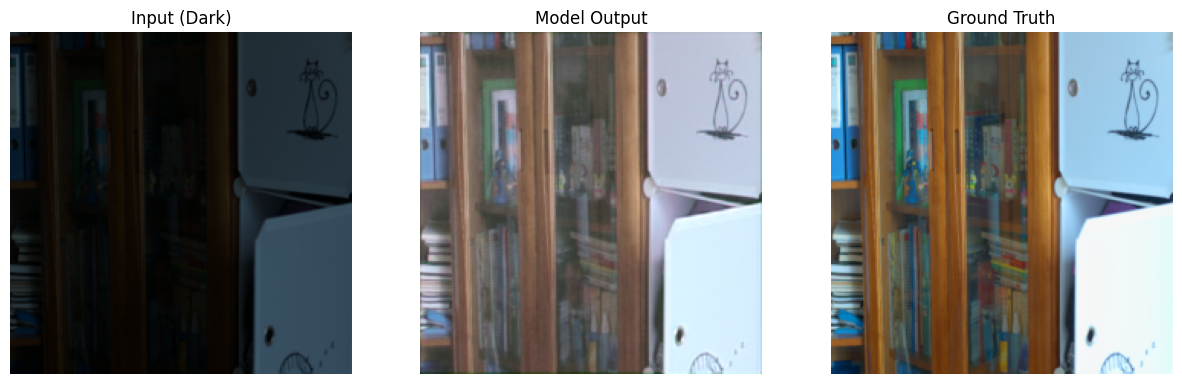

In [34]:
evaluate_and_save(system, dm)